N.B : The parts "Prediction "on the past"" and "Forecasting" can be skipped.

In [11]:
cd(@__DIR__)
include("table_reader.jl")
include("utils/utils.jl")

MAPE (generic function with 2 methods)

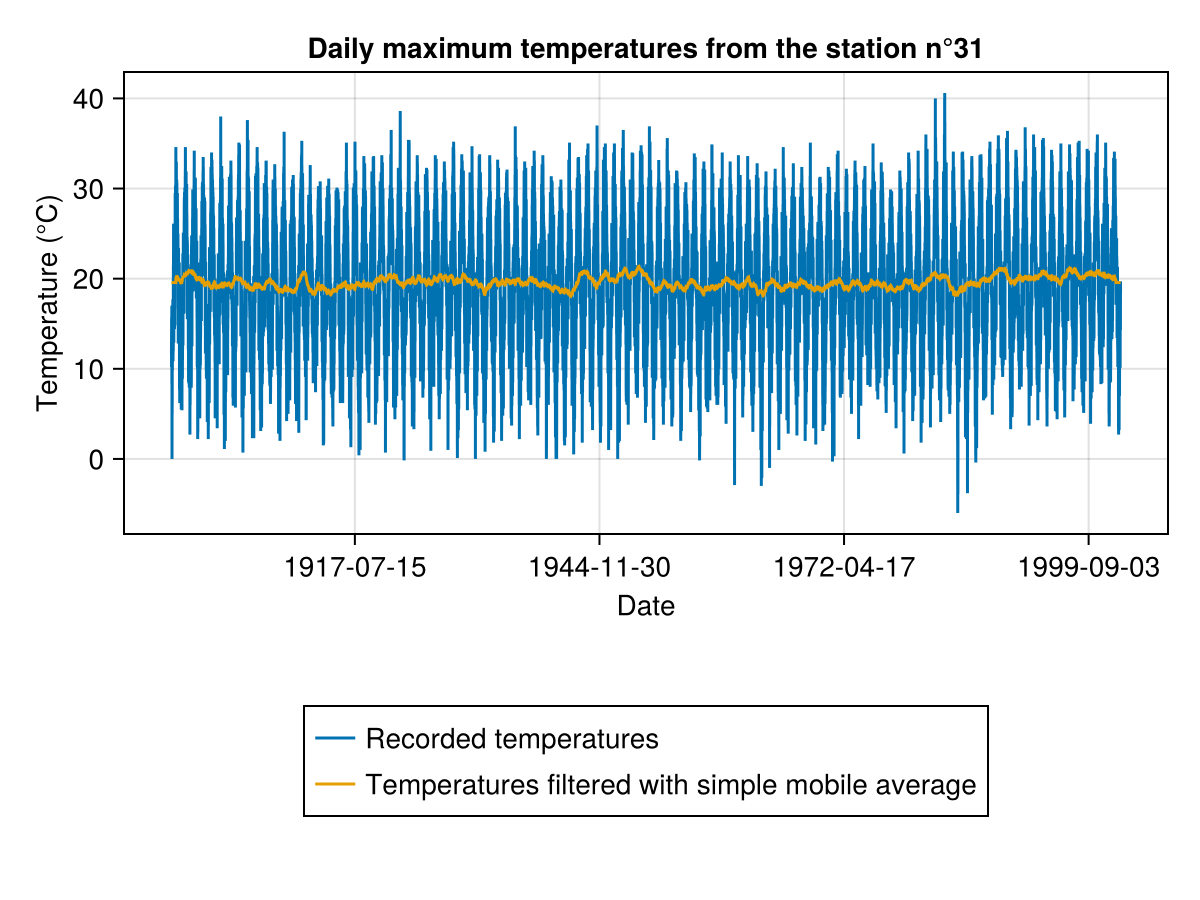

In [12]:
series,fig=extract_series("TX_STAID000031.txt",plot=true)
fig

## Drift

MSE estimators to estimate drift

In [13]:
N=size(series)[1]
X=cat(ones(N),1:N,dims=2)
beta=inv(transpose(X)*X)*transpose(X)*series[!,2]

2-element Vector{Float64}:
 19.366009056392556
  1.0215034069842917e-5

There is only a constant

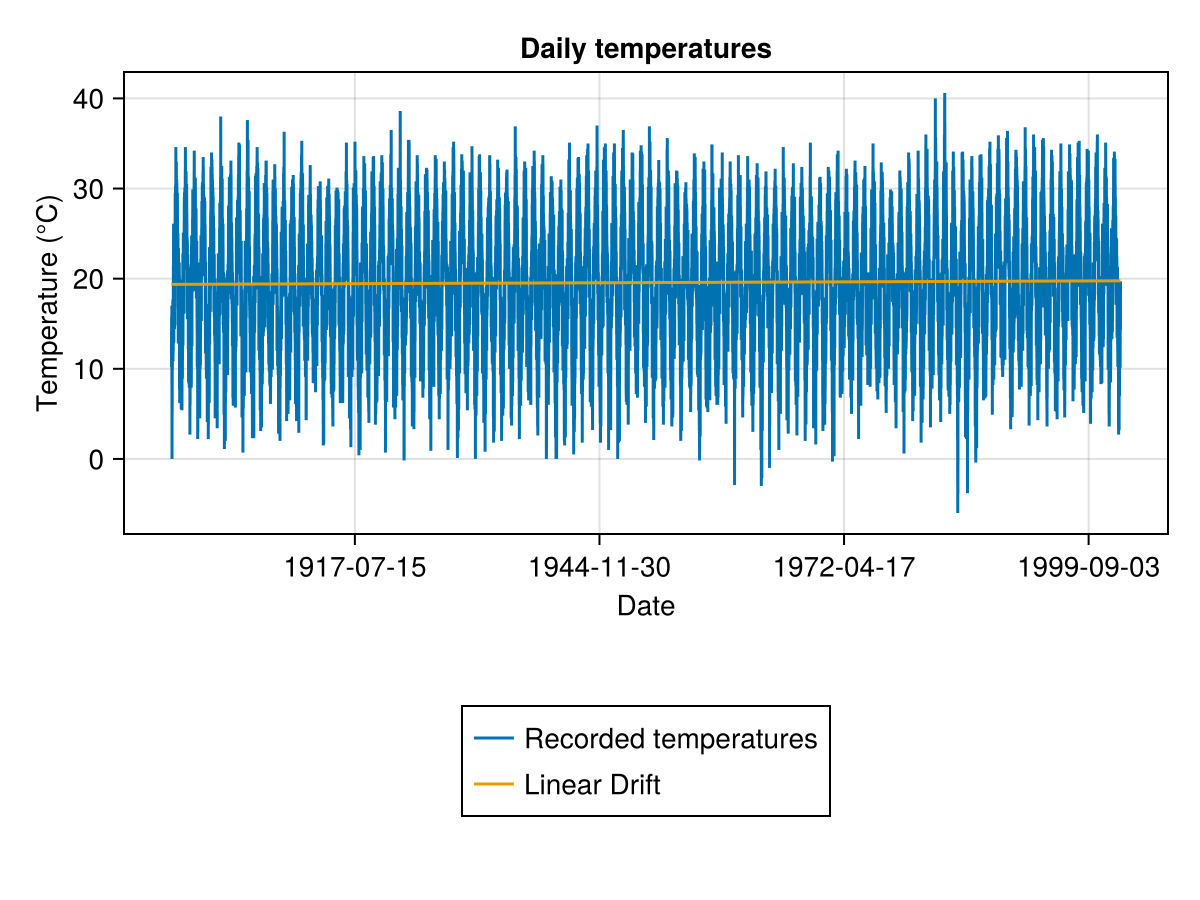

In [14]:
fig=Figure()
ax, plot1=lines(fig[1:2, 1:2], series.DATE, series[!,2])
plot2=lines!(ax,series.DATE,X*beta)
ax.title="Daily temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
Legend(fig[3, 1:2],[plot1,plot2],["Recorded temperatures","Linear Drift"])
current_figure()

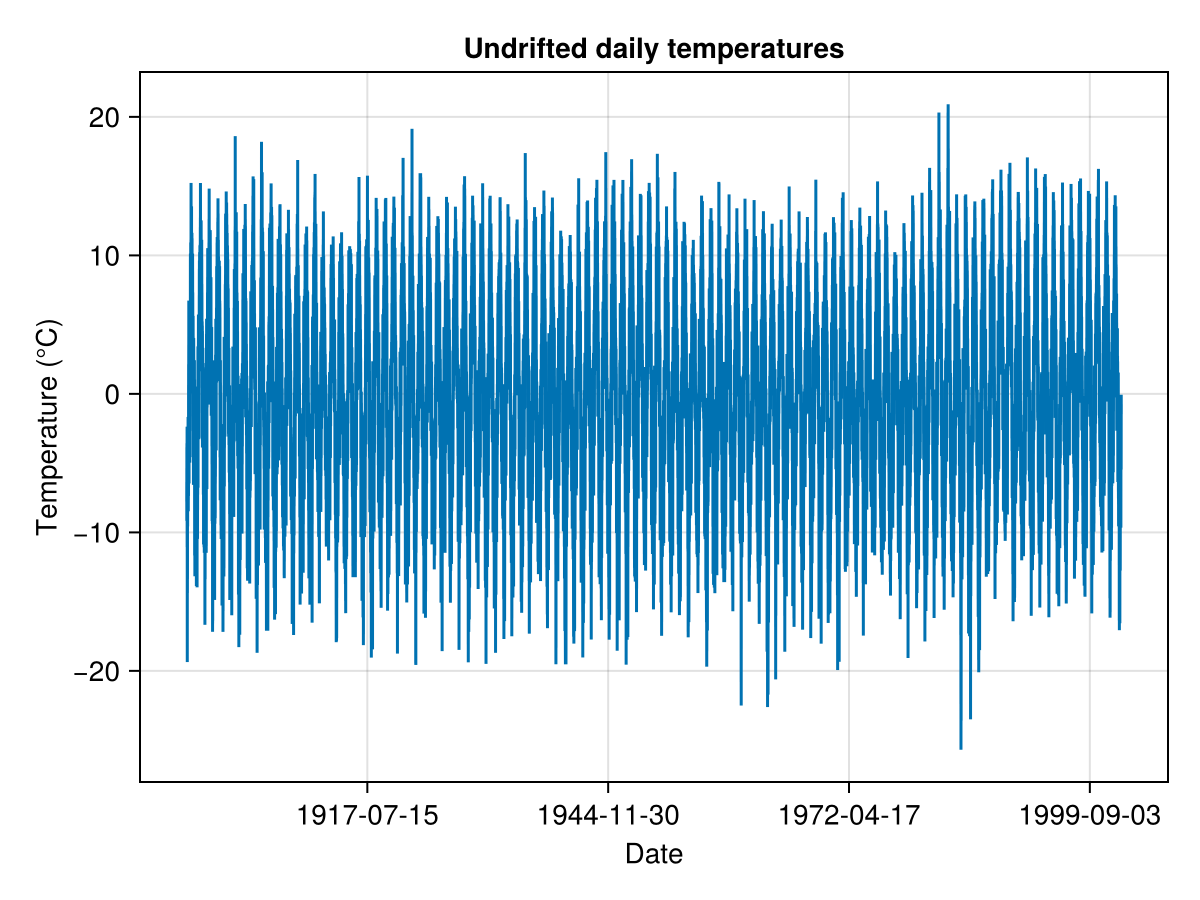

In [15]:
undrifted_series=series[!,2]-X*beta

fig, ax = lines(series.DATE, undrifted_series)
ax.title="Undrifted daily temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
current_figure()

## Periodicity

In [ ]:
k=N ÷ 365 #k : number of years
average_period=mean(undrifted_series[i:364+i] for i in 1:365:(k-1)*365)
#Bad method : it does not consider bissextile years

365-element Vector{Float64}:
 -7.840852999024626
 -7.86848226167774
 -7.472302000521335
 -7.786597929841122
 -7.358036716303765
 -7.416142169433068
 -7.493295241609997
 -7.134257837596449
 -7.360934719297186
 -7.45713541052173
  ⋮
 -8.060680027343965
 -7.8959283376161356
 -7.814986171697822
 -7.5330916248271285
 -7.524530411289771
 -8.095969197752408
 -7.9950270318341
 -7.9178943897253165
 -7.976952223807

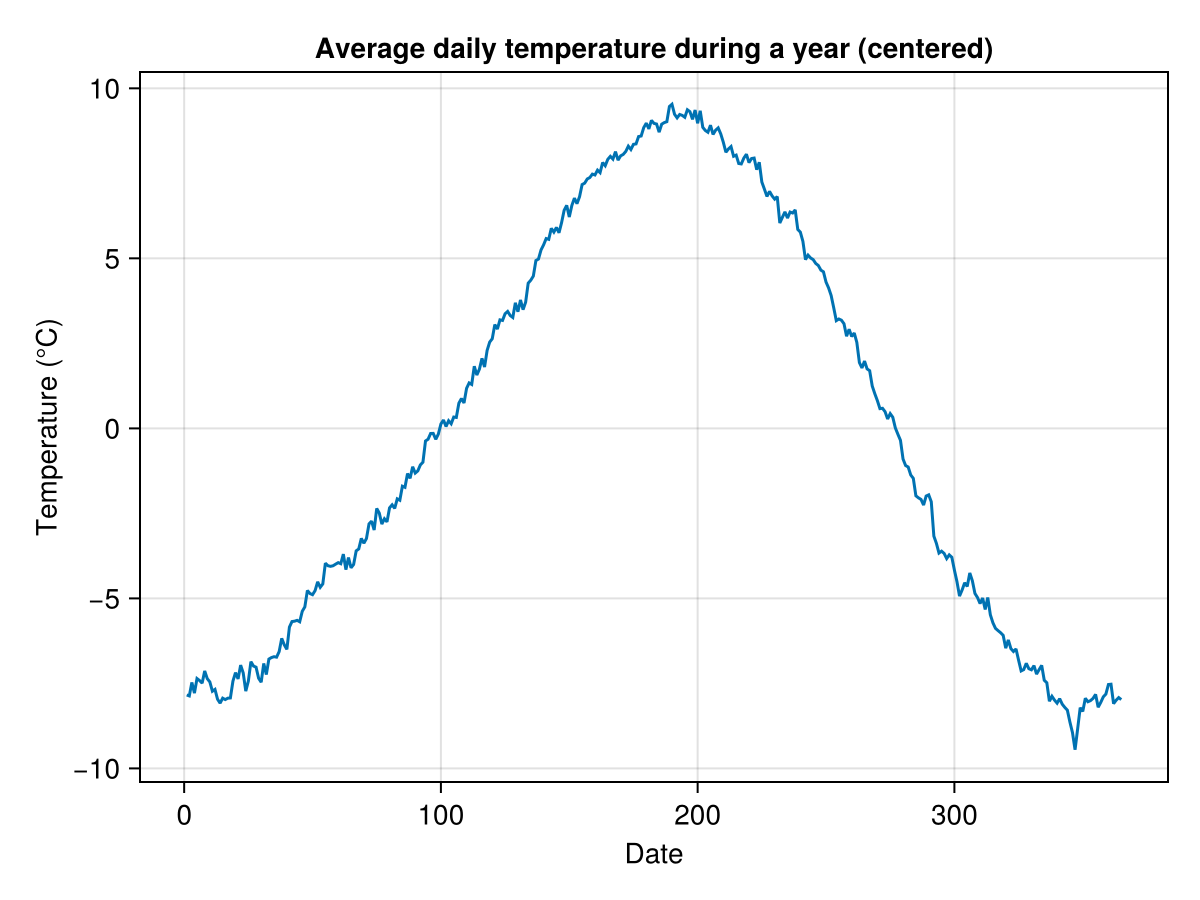

In [17]:
fig, ax = lines(1:365, average_period)
ax.title="Average daily temperature during a year (centered)"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
current_figure()

In [18]:
repeated_period=append!(repeat(average_period,outer=k),average_period[1:N % 365])
filtered_series=undrifted_series-repeated_period

38758-element Vector{Float64}:
  0.07483372759799867
  0.8024527752170441
  1.106262299026568
 -1.379451986687716
  1.9919765847408577
 -0.349928177163906
  3.6272146799789526
  2.8681670609313343
  2.6948337275980006
  3.8910242037884757
  ⋮
  2.687233107054826
  0.718661678483397
 -0.9632430834213661
 -1.3070526072308875
  0.3367569165786324
  3.538661678483394
  3.9415188213405354
  2.140566440388157
  2.7843759641976815

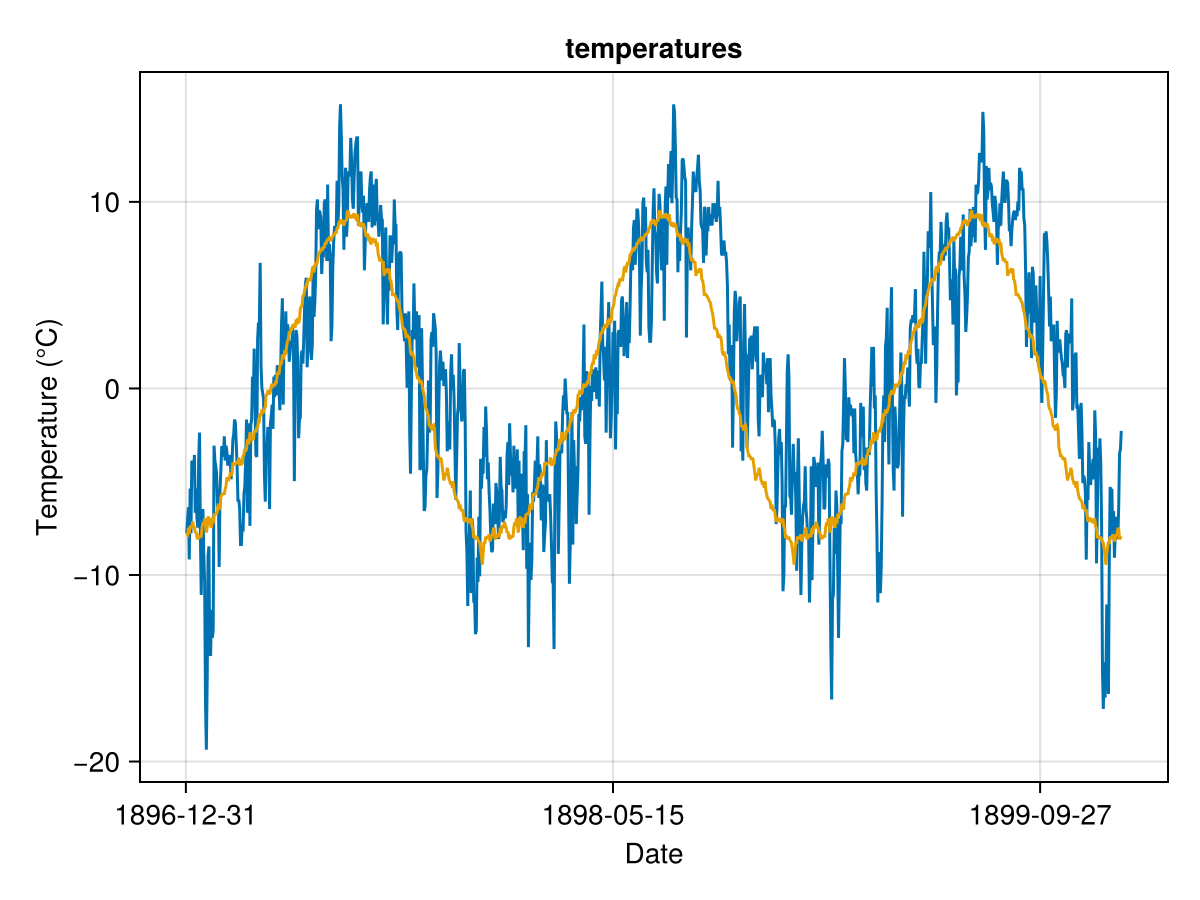

In [44]:
Myyear=Iyear(series.DATE,year(series.DATE[1]):year(series.DATE[1]) + 2)
fig, ax = lines(series.DATE[Myyear],undrifted_series[Myyear])
lines!(ax,series.DATE[Myyear],repeated_period[Myyear])
ax.title="temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
current_figure()

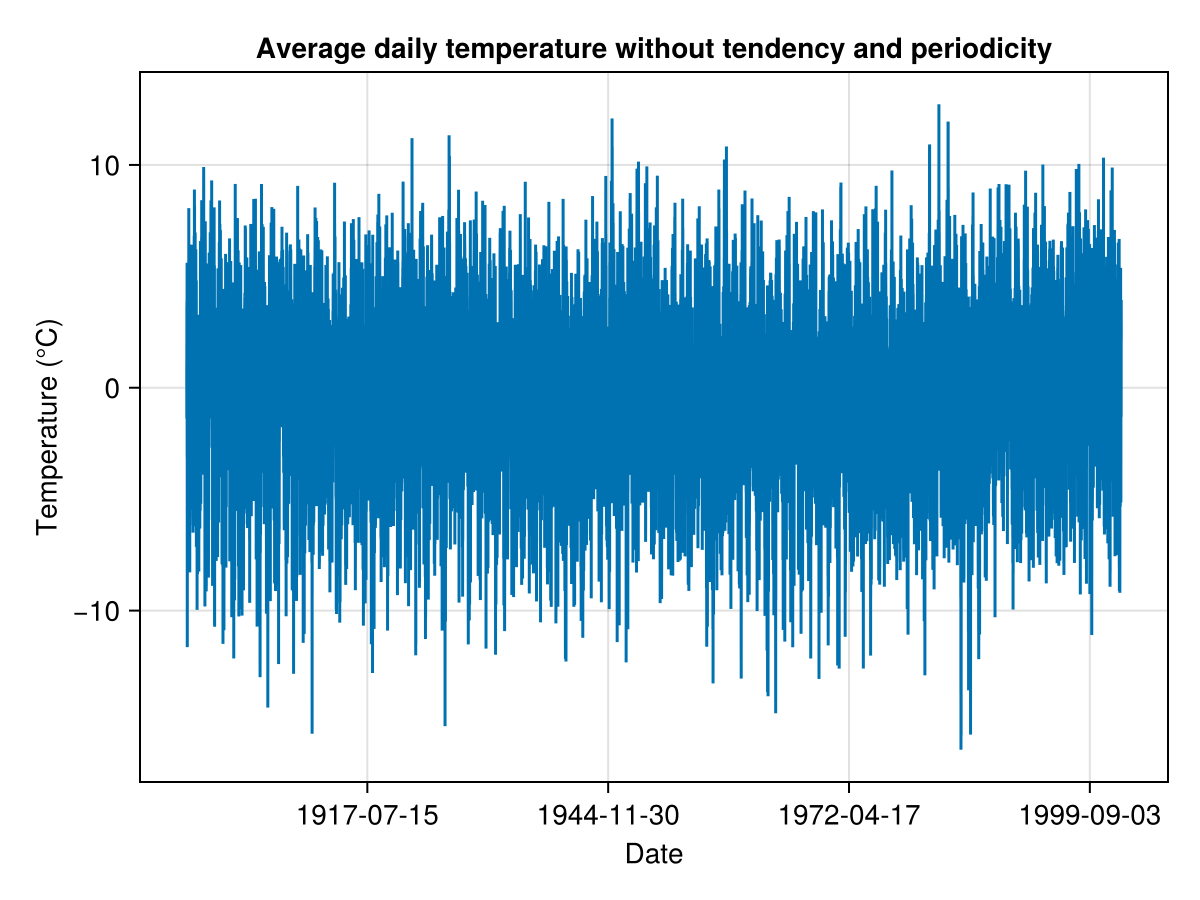

In [23]:
fig, ax = lines(series.DATE, filtered_series)
ax.title="Average daily temperature without tendency and periodicity"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
current_figure()

Exemple in 1965

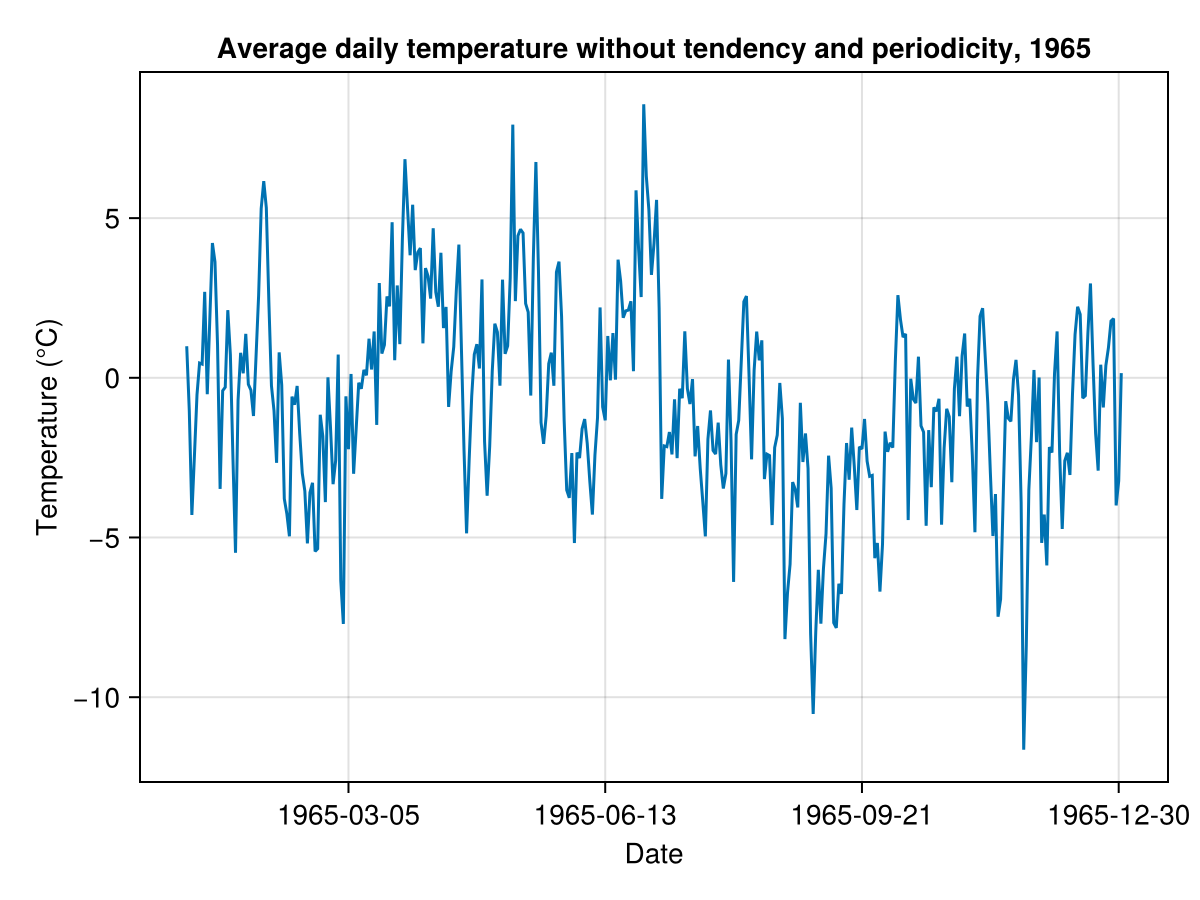

In [24]:
fig, ax = lines(series.DATE[Iyear(series.DATE,1965)], filtered_series[Iyear(series.DATE,1965)])
ax.title="Average daily temperature without tendency and periodicity, 1965"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
current_figure()

## Autocorrelations

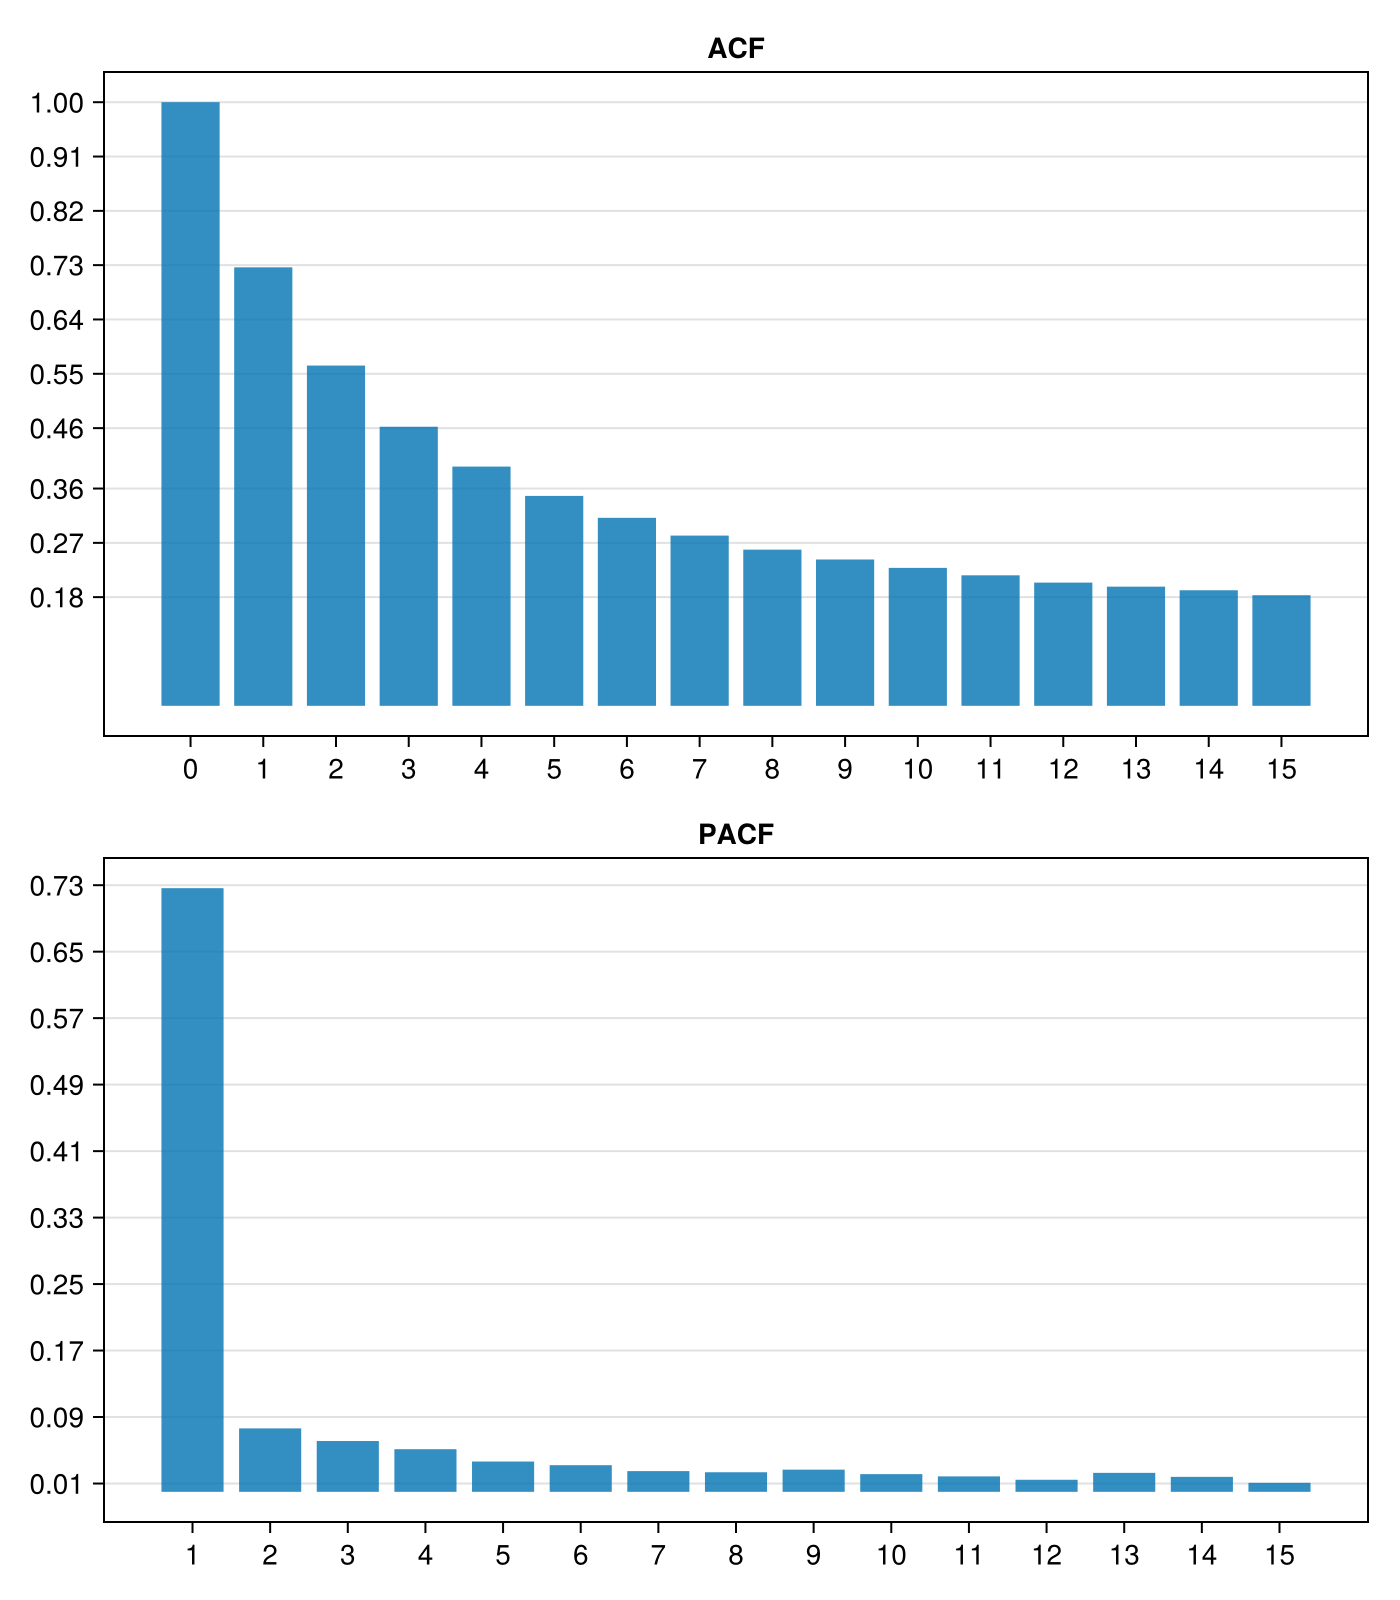

In [25]:
include("utils/ACF_PACF.jl")
ACF_PACF(filtered_series)

It looks like an AR(1) model

## Estimation with Likelihood

In [26]:
include("utils/Estimation.jl")
x=filtered_series
p=1
opt=LL_AR_Estimation(x,p)
Φ, σ=opt[1] ,opt[2]

([0.7264051566833148], 2.2012207027865984)

## Prediction "on the past" 

In [27]:
pred=[dot(Φ,x[(t-1):-1:(t-p)]) for t in (p+1):length(x)]  #+σ*randn(length(x)-1)

38757-element Vector{Float64}:
  0.054359605621020726
  0.5829058339124977
  0.8035946386572382
 -1.0020410365270003
  1.4469820631481771
 -0.2541896323606539
  2.6348274479341307
  2.0834513432897483
  1.957541116131307
  2.826460046411538
  ⋮
  1.1847977778301841
  1.9520199861747518
  0.522039549161026
 -0.6997047429368167
 -0.949449753948888
  0.24462196075149145
  2.5705020910079717
  2.863139596986106
  1.5549185005212045

In [28]:
try
    using LaTeXStrings
catch ; 
    import Pkg
    Pkg.add("LaTeXStrings")
    using LaTeXStrings
end

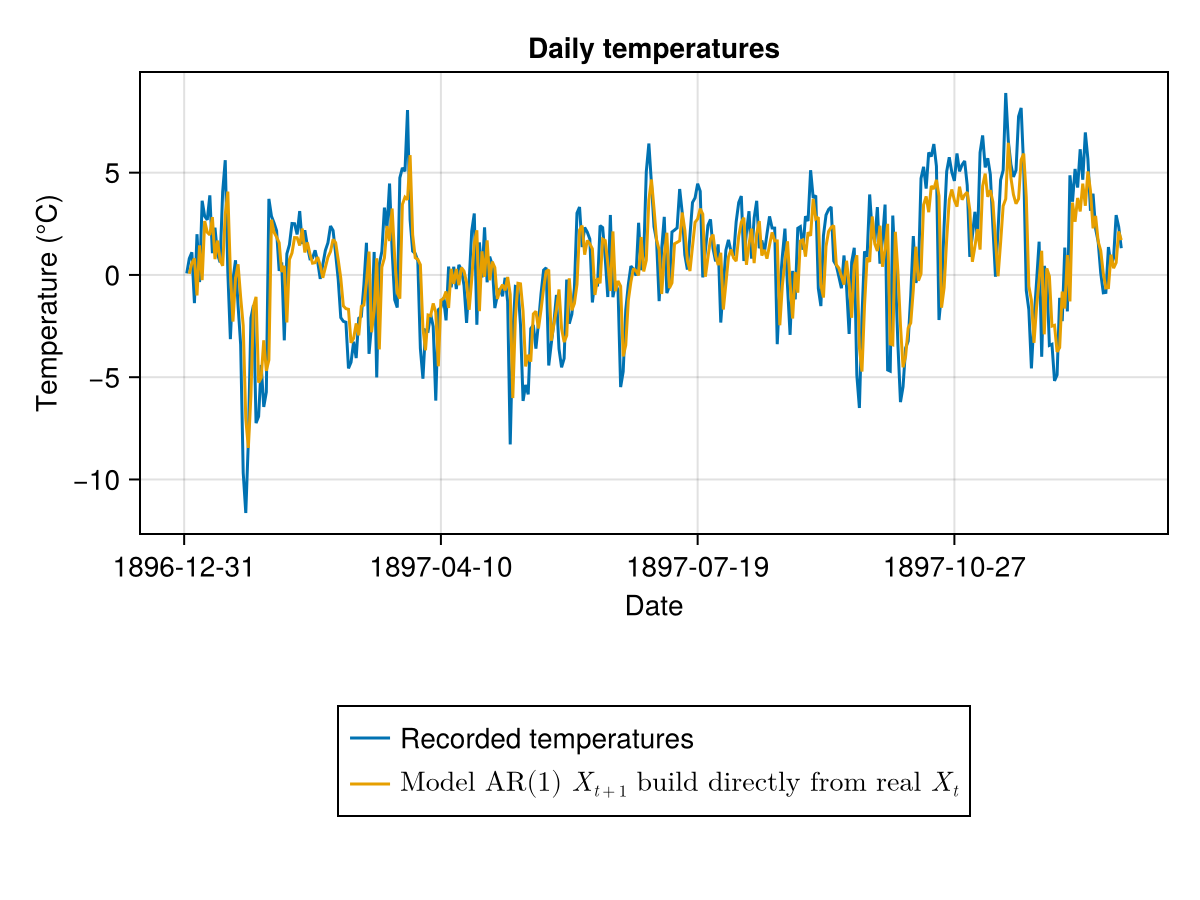

In [29]:
fig=Figure()
ax, plot1=lines(fig[1:2, 1:2], series.DATE[1:365], x[1:365])
plot2=lines!(ax,series.DATE[2:365],pred[1:364])
ax.title="Daily temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
Legend(fig[3, 1:2],[plot1,plot2],["Recorded temperatures",L"Model AR(1) $X_{t+1}$ build directly from real $X_t$"])
current_figure()

## Forecasting

In [30]:
function forecast(x::Number,Φ,n)
    #Forecast the model for n days
    prev = [x * Φ]
    if n > 1 
        for _ in 2:n
            append!(prev, prev[end] * Φ)
        end
    end
    return prev
end

forecast (generic function with 1 method)

In [31]:
prev=forecast(x[end],Φ[1],365*2)

730-element Vector{Float64}:
 2.0225850585382728
 1.4692162163528255
 1.0672462358414412
 0.7752531691660801
 0.5631478998173228
 0.40907353840268207
 0.2971531277583983
 0.2158535643282764
 0.1567971422165336
 0.1138982526592971
 ⋮
 1.6440198705124408e-100
 1.1942245116300726e-100
 8.67490843485698e-101
 6.301498220835694e-101
 4.577440802445782e-101
 3.3250766033092265e-101
 2.415352791010863e-101
 1.7545247225997277e-101
 1.2744958060248047e-101

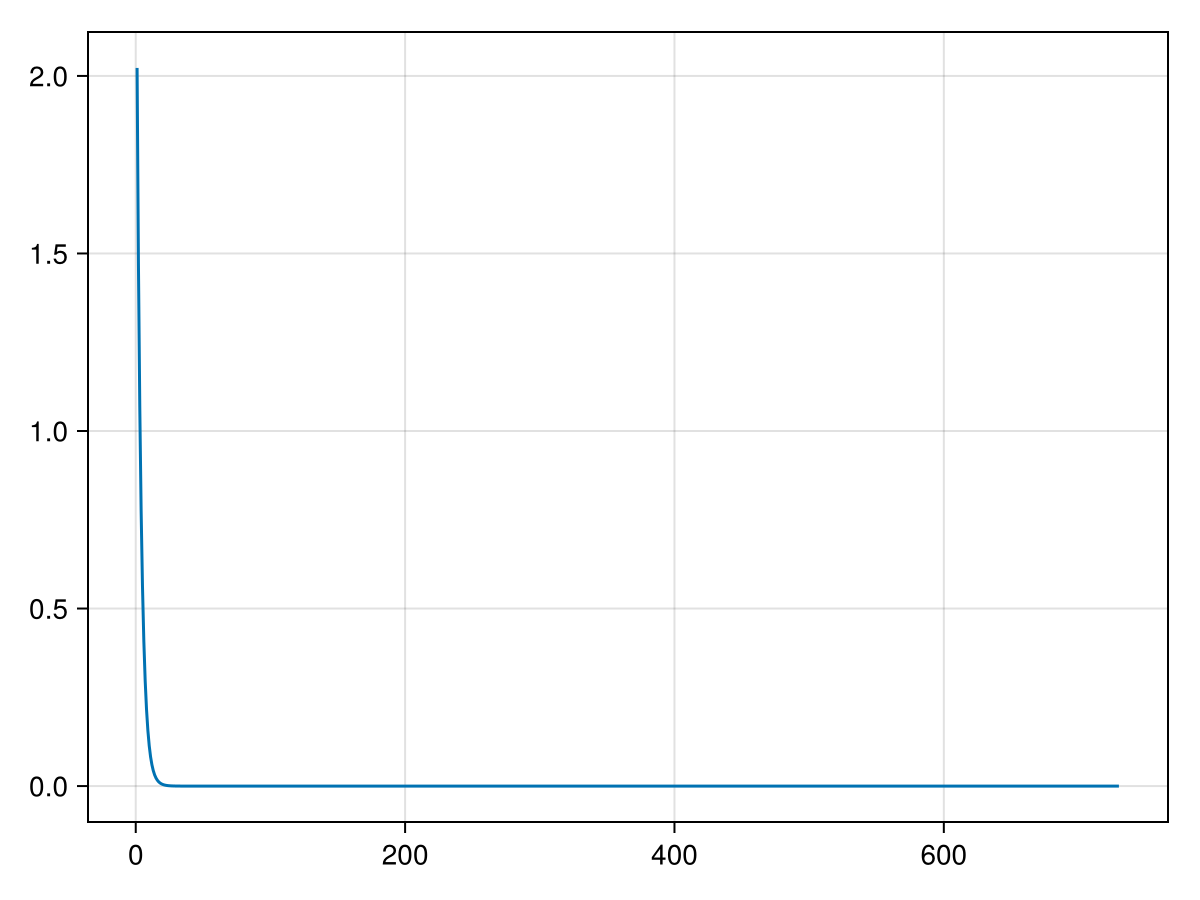

In [32]:
fig,ax,plot1=lines(1:(365*2),prev)

In [33]:
new_date_range=series.DATE[end]:Day(1):(series.DATE[end]+Day(365*2))

Date("2003-03-31"):Day(1):Date("2005-03-30")

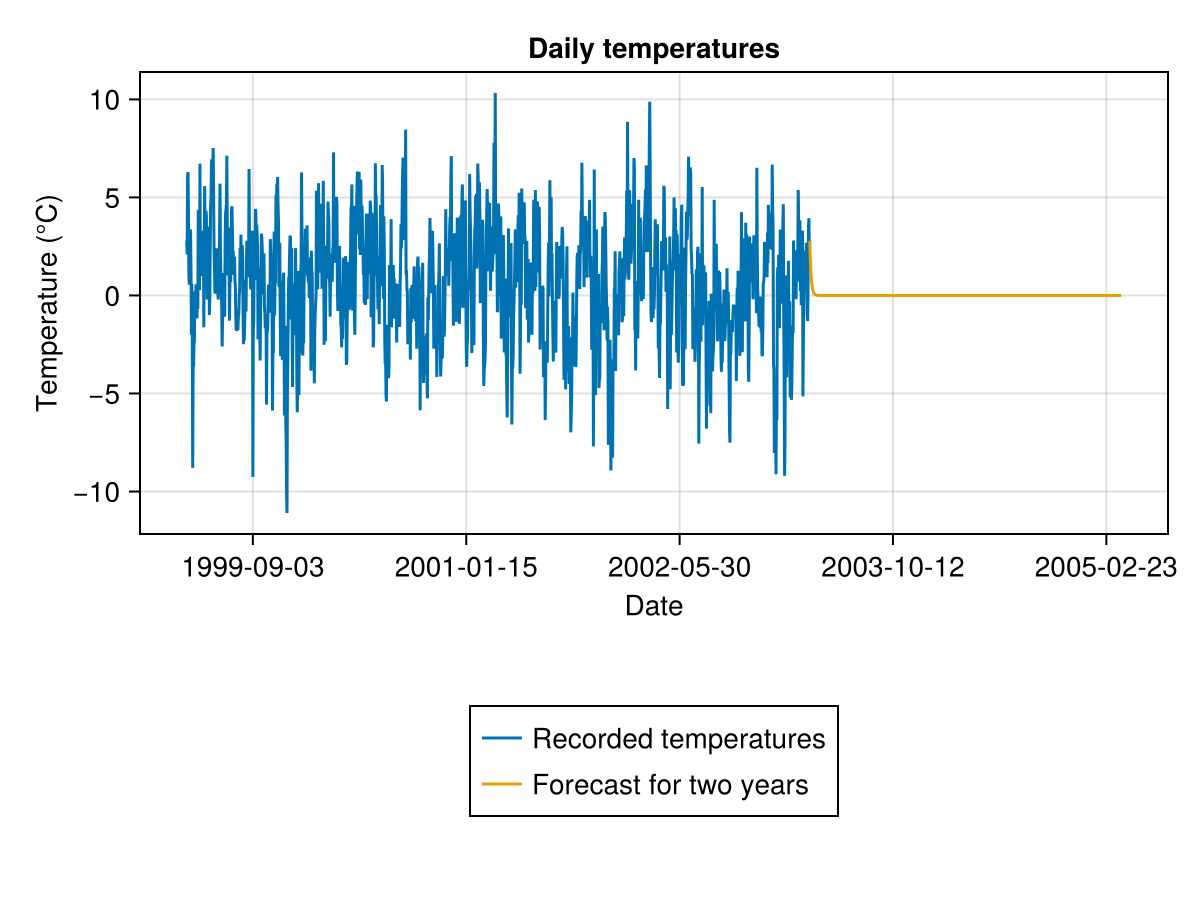

In [34]:
fig=Figure()
ax, plot1=lines(fig[1:2, 1:2], series.DATE[end-365*4:end], x[end-365*4:end])
plot2=lines!(ax,new_date_range,[x[end] ;prev])
ax.title="Daily temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
Legend(fig[3, 1:2],[plot1,plot2],["Recorded temperatures","Forecast for two years"])
current_figure()

It is not very realistic.

## Simulation

In [35]:
include("utils/Simulation.jl")
noised_prev=simulation(x[(end-p+1):end],Φ,σ,365*2)

730-element Vector{Float64}:
   3.1342939447348312
  -1.6489095958397213
  -4.086145638711442
  -9.445352386547404
  -7.178194829232675
  -9.41218211571842
 -12.455496934721289
  -6.5810254903831105
  -5.925204795909854
  -2.241205535300024
   ⋮
  -1.8251617718743705
  -3.9610526931357954
  -1.3761992695947531
  -1.2006069954294487
  -3.4178945765000135
  -3.151778910806036
  -1.3051299435285983
  -0.41595392503930484
  -0.7143365842102349

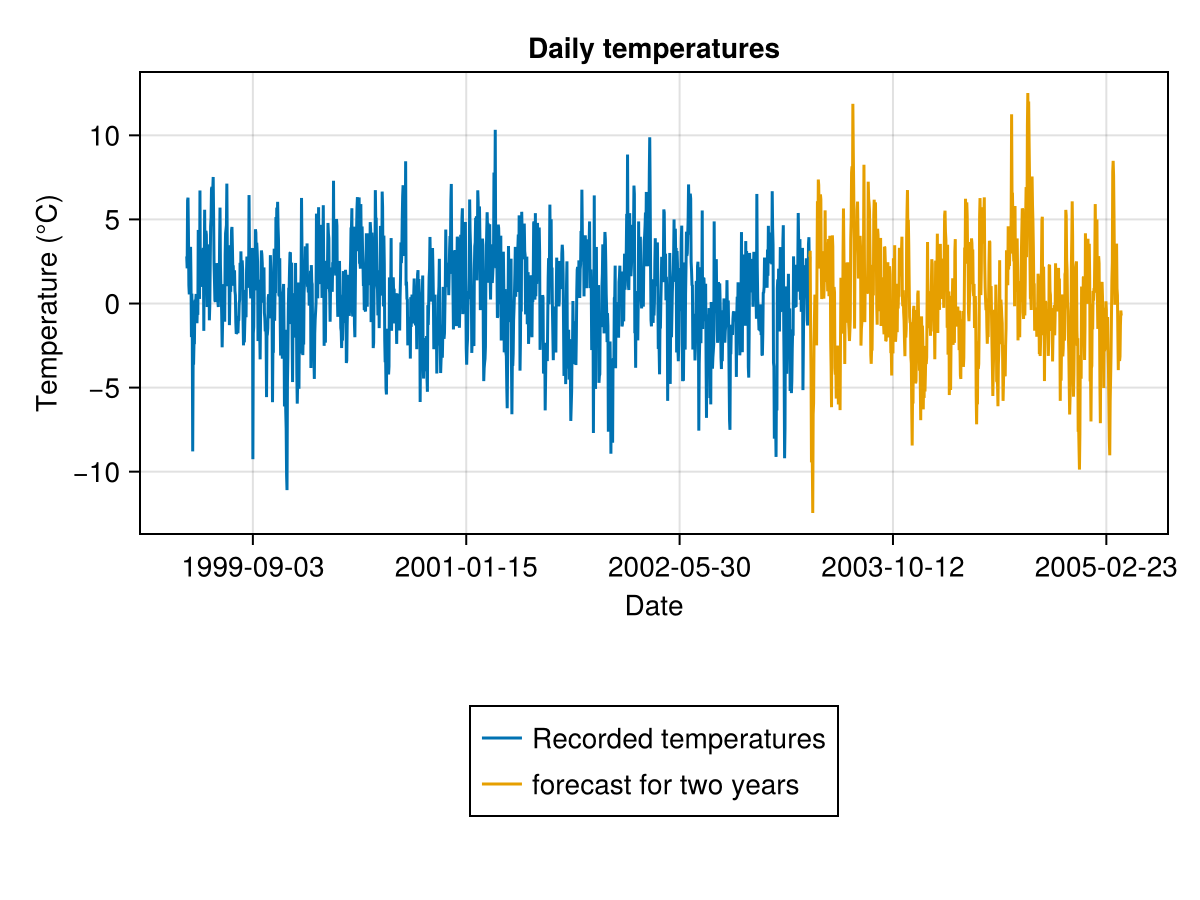

In [36]:
fig=Figure()
ax, plot1=lines(fig[1:2, 1:2], series.DATE[end-365*4:end], x[end-365*4:end])
plot2=lines!(ax,new_date_range,[x[end] ;noised_prev])
ax.title="Daily temperatures"
ax.xlabel="Date"
ax.ylabel="Temperature (°C)"
Legend(fig[3, 1:2],[plot1,plot2],["Recorded temperatures","forecast for two years"])
current_figure()

In [37]:
noised_prev_pm=noised_prev + repeat(repeated_period[end-364:end],2) .+ beta[1]

730-element Vector{Float64}:
 19.264469665500297
 14.339351147986914
 12.04020012817636
  7.11145935578252
  9.45860669806318
  6.964609196543366
  4.555569876792141
 10.292888248953393
 10.625841585535433
 14.466021107301671
  ⋮
 13.591772550864391
 11.424442843140325
 14.29119081355206
 14.010582396492817
 12.149475076578662
 12.113675765333806
 14.057457374720032
 15.347575559127636
 15.105373161113114

In [38]:
function plot_simulation(n_future_period=2,n_old_period::Int=0) #Use global variables
    new_date_range=series.DATE[end]:Day(1):(series.DATE[end]+Day(365*n_future_period))
    noised_prev=simulation(x[(end-p+1):end],Φ,σ,365*n_future_period)
    noised_prev_pm=noised_prev + repeat(repeated_period[end-364:end],n_future_period) .+ beta[1]
    fig=Figure()
    if n_old_period==0
        ax, plot1=lines(fig[1:2, 1:2], series.DATE, series.TX)
    else
        ax, plot1=lines(fig[1:2, 1:2], series.DATE[end-365*n_old_period:end], series.TX[end-365*n_old_period:end])
    end
    plot2=lines!(ax,new_date_range,[series.TX[end] ;noised_prev_pm])
    ax.title="Daily temperatures"
    ax.xlabel="Date"
    ax.ylabel="Temperature (°C)"
    Legend(fig[3, 1:2],[plot1,plot2],["Recorded temperatures","Simulation for $(n_future_period) years"])
    return fig
end

plot_simulation (generic function with 3 methods)

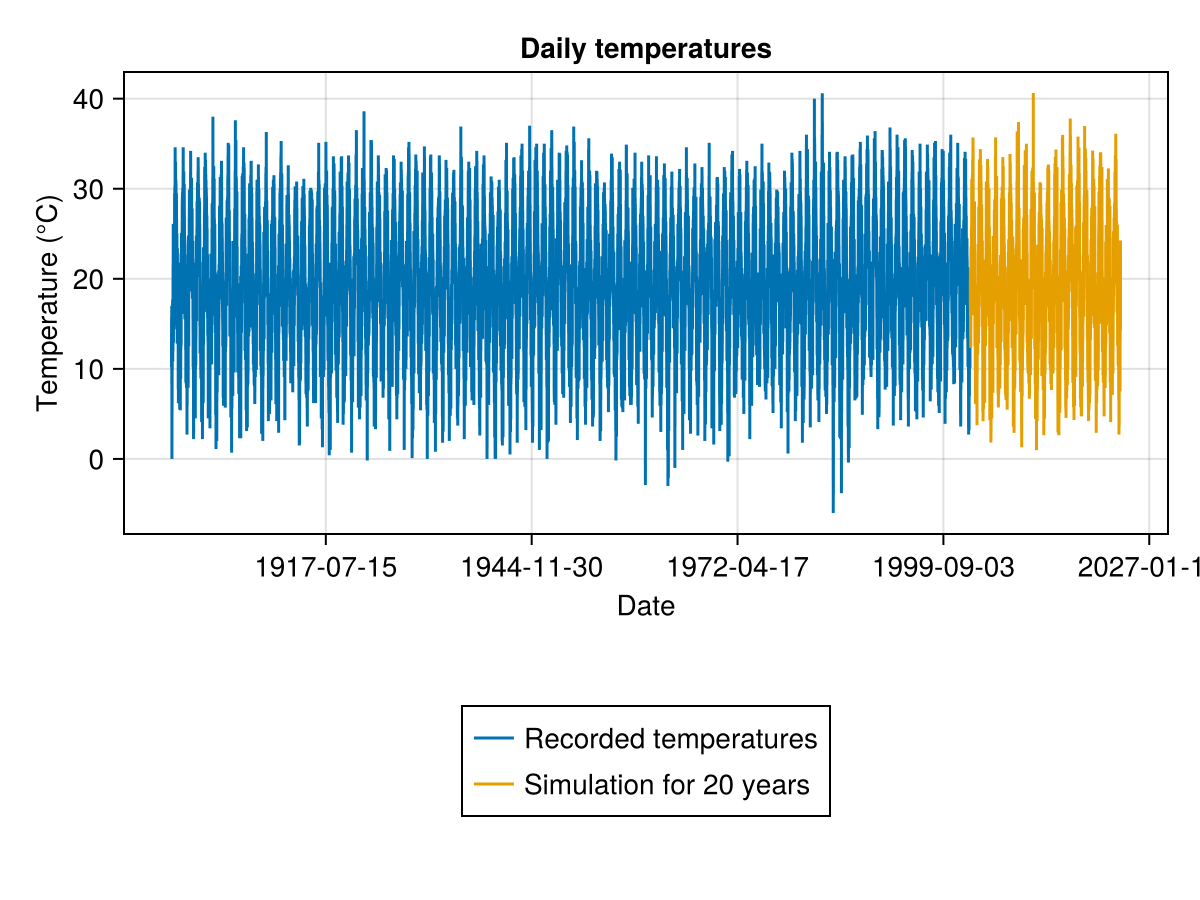

In [39]:
plot_simulation(20)

## Sampling simulations

In [40]:
sample_=invert(sample_simulation(x[1:p],Φ,σ,repeated_period,105 * 100))

365-element Vector{Vector{Float64}}:
 [-7.766019271426627, -6.264304767713851, -1.6982006740637905, -7.439888938935214, -3.984254837823462, -6.555379001461582, -12.406146468380697, -11.694272041161266, -14.282299541752383, -7.047898655882827  …  -11.191842359071288, -9.708529002732815, -9.163820226024885, -9.843545168031, -5.286347555067529, -9.872207527332009, -6.834500166672212, -9.809459906423607, -12.124427569161234, -12.156361023417734]
 [-6.56573996356151, -4.074576313882051, -2.3217754335380594, -7.002984119752733, -4.399076764514724, -4.003194721089335, -13.344698701110268, -14.213859537165852, -10.12733424533801, -8.940165866210194  …  -10.315834719559428, -8.758234825613254, -7.675938737940571, -11.203711890842138, -1.9552025407257858, -11.522318743028585, -7.017036590240397, -7.408597509758335, -10.77105318238466, -11.113045218350049]
 [-9.53798034160824, -8.07883511296195, -4.510761949464756, -8.103853459599078, -2.8972242943272217, -8.876494864493736, -13.373834114817114, 

To apply statistical functions on each days, the sample vector will be inverted (it was shaped like v[year][day], no it is shaped like v[day][year]).

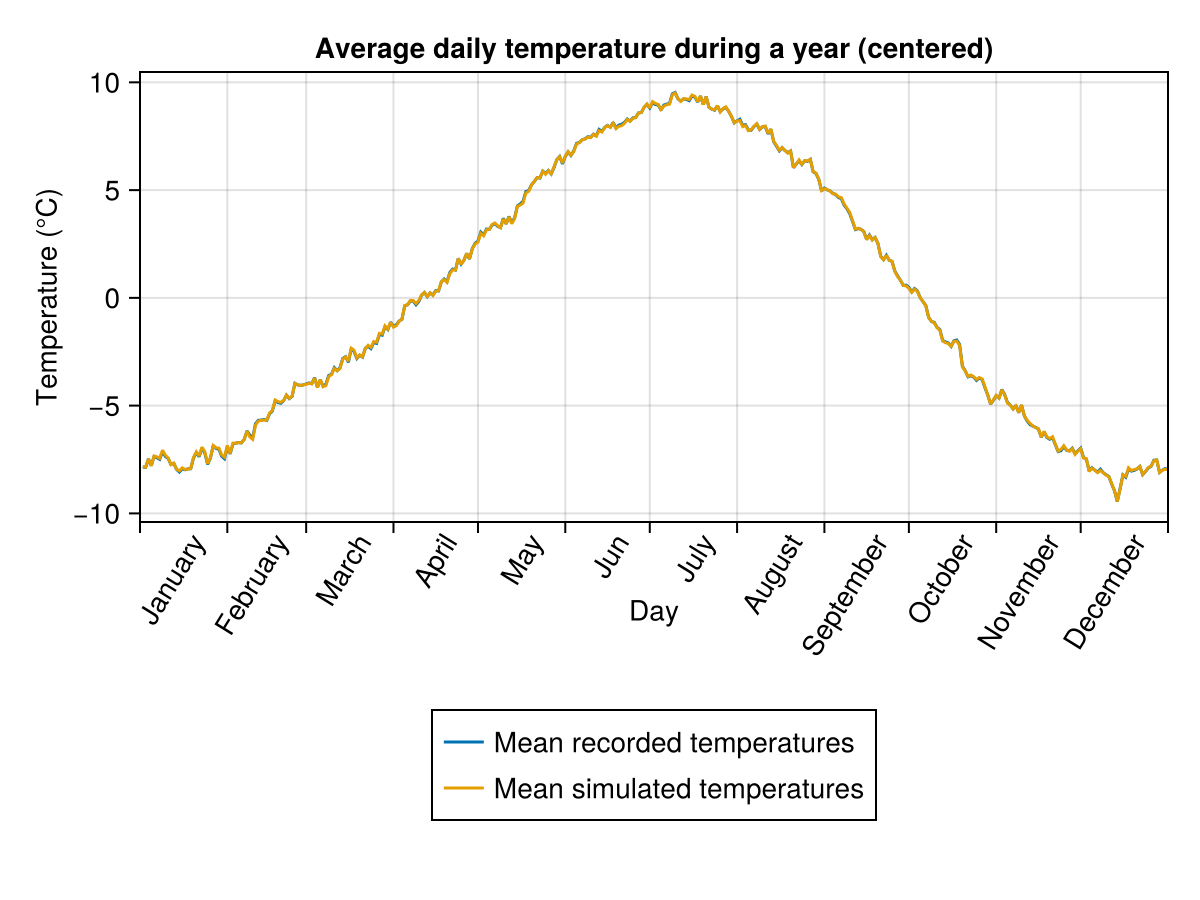

In [41]:
include("utils/Plotting.jl")
PlotYearCurves([average_period,mean.(sample_)],["Mean recorded temperatures","Mean simulated temperatures"],"Average daily temperature during a year (centered)")

The generated sample seems to be unbiased.

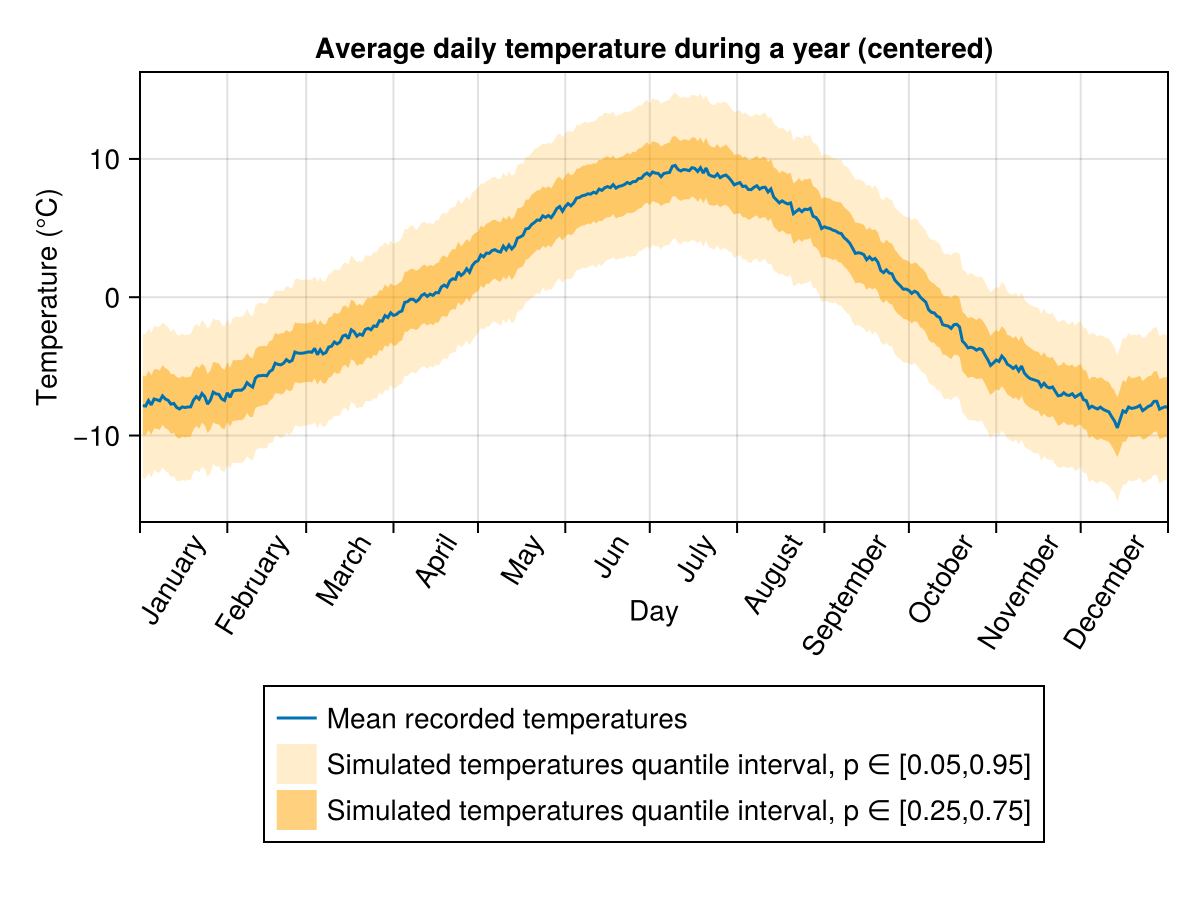

In [42]:
PlotYearCurves(average_period,
["Mean recorded temperatures","Simulated temperatures quantile interval, p ∈ [0.05,0.95]","Simulated temperatures quantile interval, p ∈ [0.25,0.75]"],
"Average daily temperature during a year (centered)",
[(quantile.(sample_,0.05),quantile.(sample_,0.95)),(quantile.(sample_,0.25),quantile.(sample_,0.75))],
[("orange",0.2),("orange",0.5)]
)